<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Predicting Weather from RDU's Weather Station

## **Dependencies**

In [59]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime   
from sklearn.model_selection import train_test_split
    

## Clean the data

In [70]:
import os
import pandas as pd
import numpy as np

# Load all CSVs
def load_all_weather_data(folder_path="Data_Raw"):
    """Loads and combines all weather CSV files in the given folder."""
    all_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]
    all_dfs = []

    for file in sorted(all_files):
        file_path = os.path.join(folder_path, file)
        print(f"Reading {file} ...")
        df = pd.read_csv(file_path)

        # Normalize column names (lowercase, strip spaces)
        df.columns = df.columns.str.strip().str.lower()

        all_dfs.append(df)

    combined = pd.concat(all_dfs, ignore_index=True)
    print(f"\nCombined dataset shape: {combined.shape[0]} rows, {combined.shape[1]} columns.")
    print(f"Columns found: {list(combined.columns)}")
    return combined


df = load_all_weather_data("Data_Raw")


# Clean the combined data
def clean_data(df):
    """Clean dataset: standardize dates, handle missing values, remove extremes carefully."""
    
    df = df.copy()
    print("\n---- Cleaning Data ----")

    # Identify date column
    date_col = None
    for col in df.columns:
        if 'date' in col or 'day' in col or 'time' in col:
            date_col = col
            break

    if date_col is None:
        raise KeyError("Could not find a date or datetime column in the dataset.")

    print(f"Using '{date_col}' as the date column.")
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Convert all non-date columns to numeric
    for col in df.columns:
        if col != date_col:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Keep only main weather variables
    weather_cols = [c for c in df.columns if not c.endswith("_source") and c != date_col]
    numeric_df = df[[date_col] + weather_cols]

    # Report missingness but don't drop all missing rows
    missing_counts = numeric_df[weather_cols].isna().sum()
    print("\nMissing values per column:")
    print(missing_counts[missing_counts > 0])

    # Drop rows where *most* weather values are missing (not all)
    threshold = len(weather_cols) * 0.7
    s2 = numeric_df.dropna(thresh=threshold)
    print(f"Dropped {len(df) - len(s2)} rows with excessive missing values.")

    # Remove extreme outliers more gently (clip instead of drop)
    s3 = s2.copy()
    for col in weather_cols:
        if s3[col].dtype in [np.float64, np.int64]:
            lower, upper = s3[col].quantile(0.01), s3[col].quantile(0.99)
            s3[col] = s3[col].clip(lower, upper)

    print(f"Cleaned dataset has {len(s3)} rows and {len(s3.columns)} columns.")
    print("-----------------------")

    return s3




cleaned_df = clean_data(df)

print("\nPreview of cleaned data:")
print(cleaned_df.head())


Reading 72306-2015.csv ...
Reading 72306-2016.csv ...
Reading 72306-2017.csv ...
Reading 72306-2018.csv ...
Reading 72306-2019.csv ...
Reading 72306-2020.csv ...
Reading 72306-2021.csv ...
Reading 72306-2022.csv ...
Reading 72306-2023.csv ...
Reading 72306-2024.csv ...
Reading 72306-2025-jan-aug.csv ...
Reading 72306-2025.csv ...

Combined dataset shape: 94293 rows, 22 columns.
Columns found: ['year', 'month', 'day', 'hour', 'temp', 'temp_source', 'rhum', 'rhum_source', 'prcp', 'prcp_source', 'wdir', 'wdir_source', 'wspd', 'wspd_source', 'wpgt', 'wpgt_source', 'pres', 'pres_source', 'cldc', 'cldc_source', 'coco', 'coco_source']

---- Cleaning Data ----
Using 'day' as the date column.

Missing values per column:
prcp     6846
wdir     1115
wpgt    93912
pres      285
cldc    32459
coco    28204
dtype: int64
Dropped 113 rows with excessive missing values.
Cleaned dataset has 94180 rows and 13 columns.
-----------------------

Preview of cleaned data:
                            day  year

# EDA

In [71]:
print(cleaned_df.shape)
print(cleaned_df.info())
print(cleaned_df.describe().T)


(94180, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 94180 entries, 0 to 94292
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     94180 non-null  datetime64[ns]
 1   year    94180 non-null  int64         
 2   month   94180 non-null  int64         
 3   hour    94180 non-null  int64         
 4   temp    94180 non-null  float64       
 5   rhum    94180 non-null  int64         
 6   prcp    87443 non-null  float64       
 7   wdir    93125 non-null  float64       
 8   wspd    94180 non-null  float64       
 9   wpgt    381 non-null    float64       
 10  pres    93954 non-null  float64       
 11  cldc    61834 non-null  float64       
 12  coco    66088 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(4)
memory usage: 10.1 MB
None
          count                           mean                            min  \
day       94180  1970-01-01 00:00:00.000000015  1970-01-01 00:00:00.

(94180, 13)
          count                           mean                            min  \
day       94180  1970-01-01 00:00:00.000000015  1970-01-01 00:00:00.000000001   
year  94,180.00                       2,019.89                       2,015.00   
month 94,180.00                           6.42                           1.00   
hour  94,180.00                          11.50                           0.00   
temp  94,180.00                          16.95                          -3.90   
rhum  94,180.00                          68.95                          23.00   
prcp  87,443.00                           0.10                           0.00   
wdir  93,125.00                         133.70                           0.00   
wspd  94,180.00                           9.46                           0.00   
wpgt     381.00                          19.62                          14.00   
pres  93,954.00                       1,018.00                       1,002.00   
cldc  61,834.00 

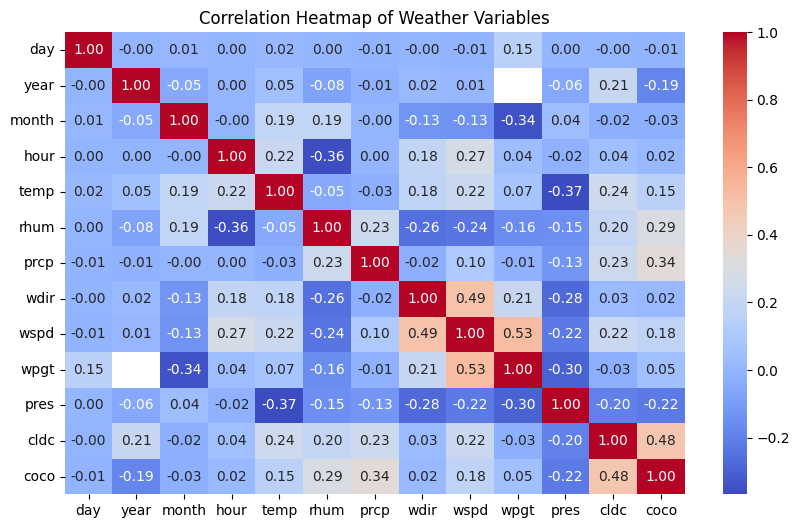

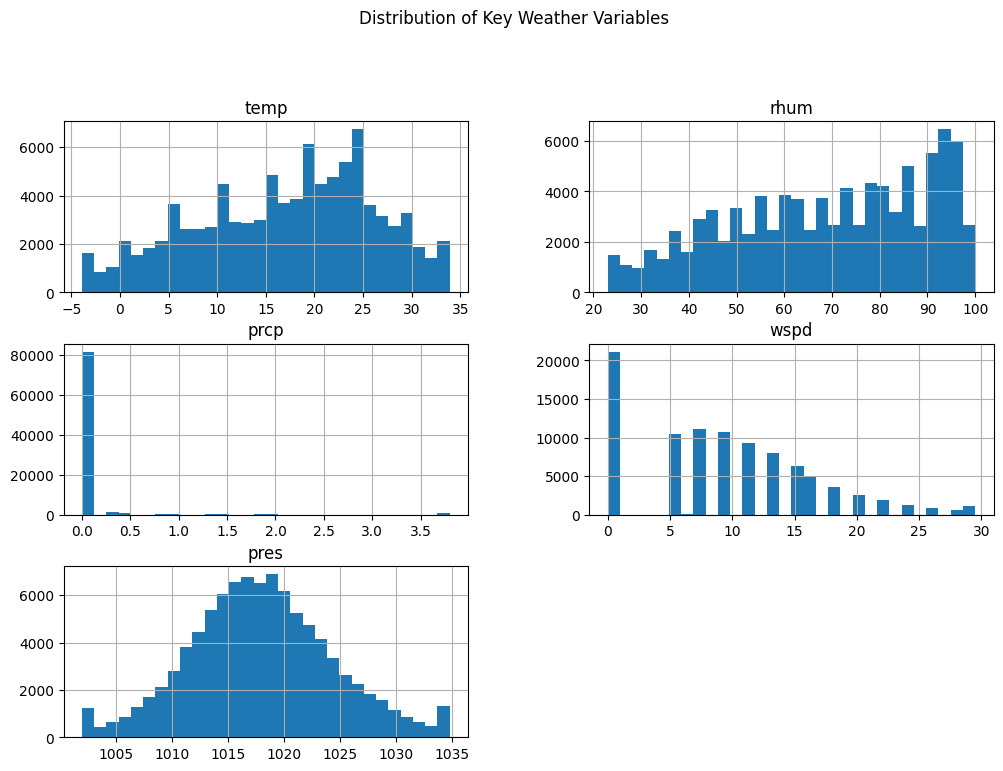

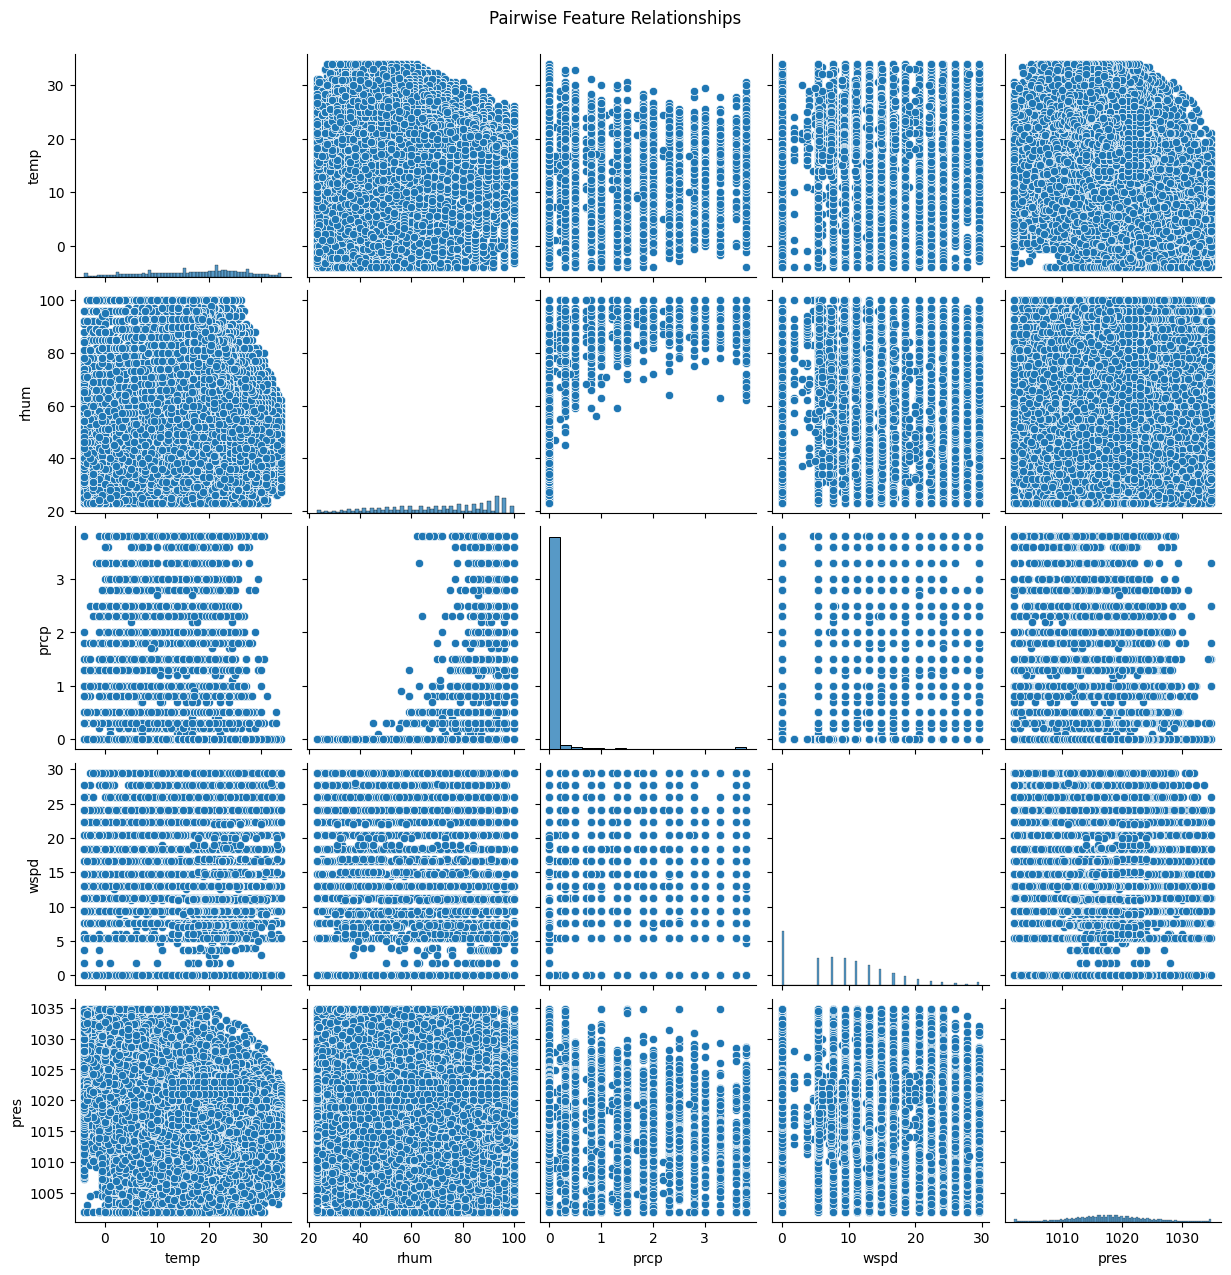

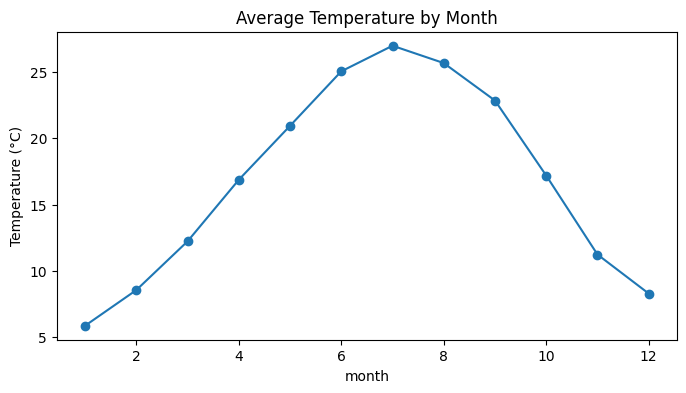

In [72]:

import seaborn as sns
import matplotlib.pyplot as plt

eda_df = cleaned_df.copy()


print(eda_df.shape)
print(eda_df.describe().T)

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(eda_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Weather Variables")
plt.show()

# Distribution plots
eda_df[['temp', 'rhum', 'prcp', 'wspd', 'pres']].hist(bins=30, figsize=(12,8))
plt.suptitle("Distribution of Key Weather Variables", y=1.02)
plt.show()

# Relationships
sns.pairplot(eda_df[['temp', 'rhum', 'prcp', 'wspd', 'pres']])
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# Seasonal trend example (if month exists)
monthly_temp = eda_df.groupby('month')['temp'].mean()
plt.figure(figsize=(8,4))
monthly_temp.plot(marker='o')
plt.title("Average Temperature by Month")
plt.ylabel("Temperature (°C)")
plt.show()
